In [11]:

import dask
import geoviews as gv
import holoviews as hv
import numcodecs
import numpy as np
import pandas as pd
import shapely
import xarray as xr
import matplotlib.pyplot as plt
import s3fs  # Importing the s3fs library for accessing S3 buckets
import time  # Importing the time library for recording execution time
import shapely  # Importing shapely for geometric operations 
import thalassa  # Importing thalassa library for STOFS data analysis
from thalassa import api  # Importing thalassa API for data handling
from thalassa import normalization
from thalassa import utils
from holoviews import opts as hvopts
from holoviews import streams
from holoviews.streams import PointerXY
from holoviews.streams import Tap
import bokeh.plotting as bp
import searvey
from datetime import datetime, timedelta, timezone
import pygrib
import tempfile

# Read STOFS Data on the Fly

In [13]:
s3 = s3fs.S3FileSystem(anon=True)  # Enable anonymous access to the S3 bucket

bucket_name = 'noaa-gestofs-pds'
key = 'stofs_2d_glo.20240410/stofs_2d_glo.t12z.fields.cwl.nc'
url = f"s3://{bucket_name}/{key}"
ds = xr.open_dataset(s3.open(url, 'rb'), drop_variables=['nvel'])  # Open NetCDF dataset and drop 'nvel' variable

#ds = xr.open_dataset('/work2/noaa/nos-surge/aalipour/STOFS-2D-Global/stofs_2d_glo.t12z.fields.cwl.nc', drop_variables=['nvel'])  # Open NetCDF dataset and drop 'nvel' variable
ds

<xarray.Dataset> Size: 20GB
Dimensions:      (time: 186, node: 12784991, nele: 24875313, nvertex: 3,
                  mesh: 1, nbou: 2530, nvel: 229434)
Coordinates:
  * time         (time) datetime64[ns] 1kB 2024-04-10T07:00:00 ... 2024-04-18
    x            (node) float64 102MB ...
    y            (node) float64 102MB ...
Dimensions without coordinates: node, nele, nvertex, mesh, nbou, nvel
Data variables:
    element      (nele, nvertex) int32 299MB ...
    adcirc_mesh  (mesh) int32 4B ...
    nvell        (nbou) int32 10kB ...
    max_nvell    int32 4B ...
    ibtype       (nbou) int32 10kB ...
    nbvv         (nvel) int32 918kB ...
    depth        (node) float64 102MB ...
    zeta         (time, node) float64 19GB ...
Attributes: (12/49)
    _FillValue:         -99999.0
    model:              ADCIRC
    version:            0d82f1a
    grid_type:          Triangular
    description:        2024041012 :-6 hr nowcast and +180 hr forecast ! 32 C...
    agrid:              OceanMesh2D
    ...                 ...
    sfea0:              45.0
    cf:                 0.0005
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               0

# Normalize data using thalassa package

In [14]:
normalized_ds = thalassa.normalize(ds)
normalized_ds

<xarray.Dataset> Size: 20GB
Dimensions:        (time: 186, node: 12784991, face: 24875313,
                    max_no_vertices: 3, mesh: 1, nbou: 2530, nvel: 229434,
                    triface: 24875313, three: 3)
Coordinates:
  * time           (time) datetime64[ns] 1kB 2024-04-10T07:00:00 ... 2024-04-18
    lon            (node) float64 102MB ...
    lat            (node) float64 102MB ...
Dimensions without coordinates: node, face, max_no_vertices, mesh, nbou, nvel,
                                triface, three
Data variables:
    face_nodes     (face, max_no_vertices) int32 299MB 0 2 3 ... 6066314 6076339
    adcirc_mesh    (mesh) int32 4B ...
    nvell          (nbou) int32 10kB ...
    max_nvell      int32 4B ...
    ibtype         (nbou) int32 10kB ...
    nbvv           (nvel) int32 918kB ...
    depth          (node) float64 102MB ...
    zeta           (time, node) float64 19GB ...
    triface_nodes  (triface, three) int32 299MB 0 2 3 ... 6066314 6076339
Attributes: (12/49)
    _FillValue:         -99999.0
    model:              ADCIRC
    version:            0d82f1a
    grid_type:          Triangular
    description:        2024041012 :-6 hr nowcast and +180 hr forecast ! 32 C...
    agrid:              OceanMesh2D
    ...                 ...
    sfea0:              45.0
    cf:                 0.0005
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               0

# Crop data Uisng Thalassa Package

In [15]:
box = (-74.5, -67, 40, 44)
bbox = shapely.box(box[0], box[2], box[1], box[3])  # Create a shapely box from the bounding box coordinates
subset_ds = thalassa.crop(normalized_ds, bbox)  # Crop the dataset using the bounding box
subset_ds

<xarray.Dataset> Size: 1GB
Dimensions:        (time: 186, node: 464899, face: 24875313,
                    max_no_vertices: 3, mesh: 1, nbou: 2530, nvel: 229434,
                    triface: 909234, three: 3)
Coordinates:
  * time           (time) datetime64[ns] 1kB 2024-04-10T07:00:00 ... 2024-04-18
    lon            (node) float64 4MB -73.68 -73.68 -73.68 ... -67.94 -68.03
    lat            (node) float64 4MB 42.75 42.75 42.75 ... 40.04 40.03 40.02
Dimensions without coordinates: node, face, max_no_vertices, mesh, nbou, nvel,
                                triface, three
Data variables:
    face_nodes     (face, max_no_vertices) int32 299MB 0 2 3 ... 6066314 6076339
    adcirc_mesh    (mesh) int32 4B ...
    nvell          (nbou) int32 10kB ...
    max_nvell      int32 4B ...
    ibtype         (nbou) int32 10kB ...
    nbvv           (nvel) int32 918kB ...
    depth          (node) float64 4MB ...
    zeta           (time, node) float64 692MB ...
    triface_nodes  (triface, three) int32 11MB 0 2 3 1 ... 218042 218043 218058
Attributes: (12/49)
    _FillValue:         -99999.0
    model:              ADCIRC
    version:            0d82f1a
    grid_type:          Triangular
    description:        2024041012 :-6 hr nowcast and +180 hr forecast ! 32 C...
    agrid:              OceanMesh2D
    ...                 ...
    sfea0:              45.0
    cf:                 0.0005
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               0

# Plot Data using Thalassa

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
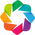

:DynamicMap   []
   :Overlay
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .Image.I :Image   [lon,lat]   (lon_lat zeta)

In [19]:
hv.extension("bokeh")
# Set some defaults for the visualization of the graphs
hvopts.defaults(
    hvopts.Image(
        width=800,
        height=600,
        show_title=True,
        tools=["hover"],
        active_tools=["pan", "box_zoom"],
        cmap="jet",
    ),
)

timestamp = pd.Timestamp(subset_ds.time[0].values)

thalassa.plot(
    ds=subset_ds.sel(time=timestamp),  # or `.isel() etc
    variable="zeta", 
    title=f"zeta: {timestamp}",
)

# Find all the CO-OPs stations in the subset area using searvey

In [16]:
station_ds= searvey.coops.coops_product_within_region('water_level', region=bbox, start_date=datetime.fromtimestamp(subset_ds.time.values[0].astype(int) * 1e-9, tz=timezone.utc)
, end_date=datetime.fromtimestamp(subset_ds.time.values[-1].astype(int) * 1e-9, tz=timezone.utc))
station_ds

<xarray.Dataset> Size: 904kB
Dimensions:  (t: 1851, nos_id: 20)
Coordinates:
  * t        (t) datetime64[ns] 15kB 2024-04-10T07:00:00 ... 2024-04-18
  * nos_id   (nos_id) object 160B '8447636' '8518962' ... '8447386' '8454049'
    nws_id   (nos_id) <U5 400B 'NBFM3' 'TKPN6' 'BRHC3' ... 'FRVM3' 'QPTR1'
    x        (nos_id) float64 160B -70.91 -73.94 -73.18 ... -71.4 -71.16 -71.41
    y        (nos_id) float64 160B 41.62 42.01 41.18 41.28 ... 41.81 41.7 41.59
Data variables:
    v        (nos_id, t) float32 148kB 6.216 6.209 6.203 ... 7.638 7.62 7.614
    s        (nos_id, t) float32 148kB 0.006 0.005 0.006 ... 0.014 0.011 0.011
    f        (nos_id, t) object 296kB '1,0,0,0' '1,0,0,0' ... '0,0,0,0'
    q        (nos_id, t) object 296kB 'p' 'p' 'p' 'p' 'p' ... 'p' 'p' 'p' 'p'

# Plot the stations 

In [87]:

variable, timestamp = "zeta", subset_ds.time.values[0]

# The trimesh is the most basic object. This is what you need to create all the others graphs
trimesh = api.create_trimesh(subset_ds.sel(time=timestamp), variable=variable)

# The wireframe is the representation of the mesh
wireframe = api.get_wireframe(trimesh)

# The tiles is using the tiling service from Open Street maps
tiles =  api.get_tiles() 

# The raster object is the basic Map that visualizes the variable. 
raster = api.get_raster(trimesh).opts(width=800, height = 600, cmap="jet", title="zeta")


stations = (station_ds['x'],station_ds['y'])
kb = gv.Points((station_ds['x'],station_ds['y'])).opts(color="red", marker="circle_dot", size=5)


raster_layout = tiles * raster * kb 
raster_layout

:DynamicMap   []
   :Overlay
      .WMTS.I   :WMTS   [Longitude,Latitude]
      .Image.I  :Image   [lon,lat]   (lon_lat zeta)
      .Points.I :Points   [Longitude,Latitude]

# Read and save the hourly observation data

In [21]:

# Initialize an empty DataFrame to store the data
Observation = pd.DataFrame()

# Loop over each nos_id
for nos_id in station_ds.nos_id:
   
       # Retrieve water level information for the specified date range
       station= searvey.coops.COOPS_Station(int(nos_id)) 
       station_df = station.product(start_date=datetime.fromtimestamp(subset_ds.time.values[0].astype(int) * 1e-9, tz=timezone.utc)
, end_date=datetime.fromtimestamp(subset_ds.time.values[-1].astype(int) * 1e-9, tz=timezone.utc), product='water_level',datum='MSL')
      
       # Resample the data to hourly frequency
       hourly_ds = station_df.resample(t='1h').mean() 

       # Add the data for the current station to the result DataFrame
       flattened_values = np.concatenate(hourly_ds['v'].values)
       Observation[int(nos_id)] = flattened_values


Observation

,8447636,8518962,8467150,8465705,8447435,8418150,8461490,8510560,8443970,8452944,8531680,8419870,8516945,8518750,8449130,8447930,8452660,8454000,8447386,8454049
0,-0.4081,1.2171,0.6800,0.5372,0.7362,0.4609,0.0864,0.0252,0.7547,-0.4434,-0.6304,0.7167,0.9677,-0.5613,0.7059,-0.0068,-0.3984,-0.4528,-0.4818,-0.4168
1,-0.4491,1.0551,0.0290,-0.0122,0.3084,-0.5424,-0.1773,-0.1856,-0.1629,-0.3878,-0.6091,-0.1535,0.1098,-0.7175,0.4067,-0.1417,-0.3936,-0.3603,-0.3884,-0.4023
2,-0.3470,0.7716,-0.5294,-0.5238,-0.0333,-1.3929,-0.3229,-0.2538,-1.1233,-0.3341,-0.3034,-0.9434,-0.6075,-0.5426,0.0567,-0.1954,-0.2650,-0.3605,-0.3267,-0.2947
3,-0.1037,0.5248,-0.9388,-0.9070,-0.2773,-1.7903,-0.2640,-0.1219,-1.7699,-0.1252,0.1670,-1.4571,-0.9455,-0.0564,-0.2970,-0.1112,0.0148,-0.1583,-0.1524,-0.0441
4,0.3001,0.2710,-1.0808,-0.9913,-0.4552,-1.7059,-0.0115,0.1181,-1.8402,0.2911,0.6429,-1.5084,-1.0605,0.4833,-0.4875,0.0918,0.4125,0.2871,0.2426,0.3538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,0.5128,-0.2485,0.1534,0.1615,-0.6906,-0.1188,0.3806,0.3435,-0.1916,0.6061,0.6653,-0.2333,0.0280,0.6245,-0.1470,0.2540,0.5133,0.6413,0.6444,0.5391
182,0.4618,-0.1655,0.5073,0.4718,-0.3662,0.4160,0.4592,0.3918,0.3279,0.5385,0.6179,0.2449,0.5228,0.6313,-0.0038,0.2617,0.4490,0.5666,0.5703,0.4803
183,0.2948,0.0377,0.8147,0.7367,-0.0656,0.8393,0.5003,0.4044,0.8146,0.3702,0.4863,0.6415,0.8851,0.5573,0.1539,0.2070,0.3059,0.4131,0.3783,0.3298
184,0.1176,0.2752,0.9798,0.8885,0.1866,1.0440,0.4584,0.3523,1.0829,0.1481,0.3058,0.8926,1.0390,0.3879,0.2964,0.1521,0.1181,0.1764,0.1583,0.1215


# find the closest node to each station

In [81]:
# Initialize an empty DataFrame to store the data
index = pd.DataFrame()

# Initialize an empty DataFrame to store the data
data = []

for nos_id, x, y in zip(station_ds['nos_id'], station_ds['x'], station_ds['y']):
    index_value = thalassa.utils.get_index_of_nearest_node(subset_ds, x, y)
    data.append({'nos_id': nos_id.item() , 'index_value': index_value})

# Convert the list of dictionaries to a DataFrame
index = pd.DataFrame(data)
index 

,nos_id,index_value
0,8447636,256776
1,8518962,7663
2,8467150,77470
3,8465705,91083
4,8447435,344171
5,8418150,146364
6,8461490,219983
7,8510560,436364
8,8443970,105417
9,8452944,135834


In [84]:
# Initialize an empty DataFrame to store the data
Forecast = pd.DataFrame()

# Loop over each nos_id
for nos_id in station_ds.nos_id:
   

       # Add the foreact data for the current station to the result DataFrame
       subset_values = subset_ds['zeta'].isel(node=index.index_value[index['nos_id'] == nos_id])
       flattened_values = np.concatenate(subset_values.values)
       Forecast[int(nos_id)] = flattened_values

# Display the resulting DataFrame
Forecast

,8447636,8518962,8467150,8465705,8447435,8418150,8461490,8510560,8443970,8452944,8531680,8419870,8516945,8518750,8449130,8447930,8452660,8454000,8447386,8454049
0,-0.528922,0.822417,0.472289,0.343611,0.939327,0.619166,-0.166453,-0.197794,0.893427,-0.606208,-0.858345,0.904622,0.720578,-0.698446,NaN,NaN,-0.566733,-0.634546,NaN,-0.550735
1,-0.556833,0.658144,-0.124835,-0.172802,0.430203,-0.318612,-0.433679,-0.431141,0.035628,-0.521088,-0.889995,0.052855,-0.072434,-0.877190,NaN,NaN,-0.561922,-0.441340,NaN,-0.543798
2,-0.536148,0.362794,-0.657004,-0.655447,-0.034530,-1.164545,-0.574121,-0.508148,-0.961142,-0.521233,-0.633317,-0.734000,-0.708621,-0.757758,NaN,NaN,-0.442762,-0.539076,NaN,-0.454118
3,-0.304047,0.128259,-1.065631,-1.049842,-0.376082,-1.782180,-0.482169,-0.396941,-1.709956,-0.340344,-0.170293,-1.318554,-1.077604,-0.320747,NaN,NaN,-0.203857,-0.349731,NaN,-0.254861
4,0.126751,-0.050391,-1.229619,-1.128386,-0.562112,-1.886600,-0.199163,-0.153551,-1.896368,0.056792,0.301776,-1.665366,-1.213952,0.158640,NaN,NaN,0.178484,0.032922,NaN,0.140915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,0.245370,-0.391707,-0.353882,-0.285803,-0.635773,-0.510304,0.039183,-0.039011,-0.592247,0.364484,0.339180,-0.585435,-0.612718,0.269006,NaN,NaN,0.272232,0.429564,NaN,0.318128
182,0.234026,-0.408270,0.067264,0.076583,-0.347583,0.005008,0.177372,0.065937,-0.093937,0.288754,0.310064,-0.123209,0.023580,0.322743,NaN,NaN,0.256743,0.303991,NaN,0.292608
183,0.183722,-0.249327,0.456371,0.402697,-0.008513,0.467233,0.281706,0.144433,0.421758,0.177687,0.172356,0.268971,0.532783,0.261254,NaN,NaN,0.170330,0.207552,NaN,0.197617
184,0.074122,-0.003762,0.742482,0.676271,0.307740,0.790932,0.289338,0.138425,0.734481,0.076056,-0.019620,0.580831,0.754934,0.102551,NaN,NaN,0.041373,0.104021,NaN,0.071051


In [91]:
subset_ds['zeta'].isel(node=index.index_value[14]+1).values

array([ 0.56591662,  0.31324392, -0.06548322, -0.44357653, -0.71664073,
       -0.69671564, -0.53884742, -0.32007473, -0.09740499,  0.17015196,
        0.3906466 ,  0.45592961,  0.43533216,  0.30784007,  0.06258524,
       -0.24727603, -0.49116107, -0.48157099, -0.35242222, -0.13254549,
        0.10545974,  0.37325521,  0.62148095,  0.67744984,  0.64728262,
        0.51113027,  0.2265349 , -0.15282396, -0.52145824, -0.72243325,
       -0.68367452, -0.52873487, -0.32380822, -0.10137165,  0.17003309,
        0.35768804,  0.41283479,  0.38578035,  0.23779877, -0.01517776,
       -0.30217765, -0.46915449, -0.42011036, -0.26587585, -0.0558863 ,
        0.1890798 ,  0.4519688 ,  0.68358114,  0.71876267,  0.71418913,
        0.47232829,  0.167513  , -0.21461296, -0.51326229, -0.62016235,
       -0.54620757, -0.37463646, -0.16417075, -0.00686654,  0.1928806 ,
        0.36078656,  0.36675305,  0.29806028,  0.10453696, -0.1321002 ,
       -0.3686978 , -0.44306567, -0.39419966, -0.22699662, -0.05